# Compare both devices
Here I will compare the measurements of Solexperts with the measurements made with the Lios device.

The data of Solexperts has been measured directly in a loop. So the temperatures of the single channel measurements are not avaible. In our measurements I avearage the results from the DTS device. Therfore I also delete a few datapoints (about 8, depending on channel), otherwise a positions, wich is in the watertank would be aveargaed with a position not in watertank. It still needs to be optimized which positions I delete. I wanted to mention it here, but I dont think you have to bother with it.

## Summary Differences
* The measurements of Solexperts have a longer cable. Our device automaticly detects 1708 m of cable length in channel 5 and 6. Their result have a length of 1738 m --> evntl nachfragen, ob die so vom Gerät bestimmt wurden oder nachträglich bearbeitet.
* Watertank Temperature is different, about 1.5 °C
  * I think our measurements are wrong
  * in heating phases, my correction of the DTS values is not very suitable, because the PT sensors measures always a cooler temperature than the DTS because the DTS is closer to the heat source.
    * I think in the long run I will add a static correction for the DTS measurements. So the Watertank measurements are not directly needed anymore (I would keep them as controle). But this needs a bit more investigations.
* Data of Solexperts does not have strong peaks at bend-point of cable. I guess thats due to different internal processing if the data?

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import pickle

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv
from my_func_mvw.functions import read_pickle, find_nearest_date

importer = "pickle" #pickle csv
path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# Output from Mathis:
# Some Version information of the imported packages
# pandas: 1.2.3
# pickle: 4.0
# Python 3.8.8

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [18]:
# import solexperts data
# 20s
path_to_solexperts = path_to_my_database + "\Solexperts_EGRT"
filename=r"\alle Messungen_TEMP.txt"

temp_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
temp_sol.index.names = ["Length [m]"]
temp_sol.index = temp_sol.index.astype(int)
temp_sol.columns.names = ["Date"]
temp_sol.columns= pd.to_datetime(temp_sol.columns)
temp_sol = temp_sol.T

temp_sol_short = temp_sol[::5] # use less dates

In [19]:
# import solexperts t_logger
filename = "\wagoTemperatur_korigiert.txt"
tlogger_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
tlogger_sol.columns.names = ["Dates"]
tlogger_sol.columns= pd.to_datetime(tlogger_sol.columns)
tlogger_sol.index=["Watertank"]
tlogger_sol.index.names = [""]
tlogger_sol = tlogger_sol.T

In [20]:
# import my_database

if importer == "pickle":
    data_2021 = import_my_database_pickle(2021,path_to_my_database + r"\pickle")
if importer == "csv":
    data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

# import my final temperatures
my_final_mean = read_pickle("final_shiftfirst")
my_final_mean_56 = read_pickle("final_shiftfirst_56")

# import my tlogger
df_Tlogger_PT100  = read_pickle(path_to_my_database + "/t_logger_watertank/Tlogger_PT100_outdated")
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "/t_logger_watertank/Tlogger_PT1000")

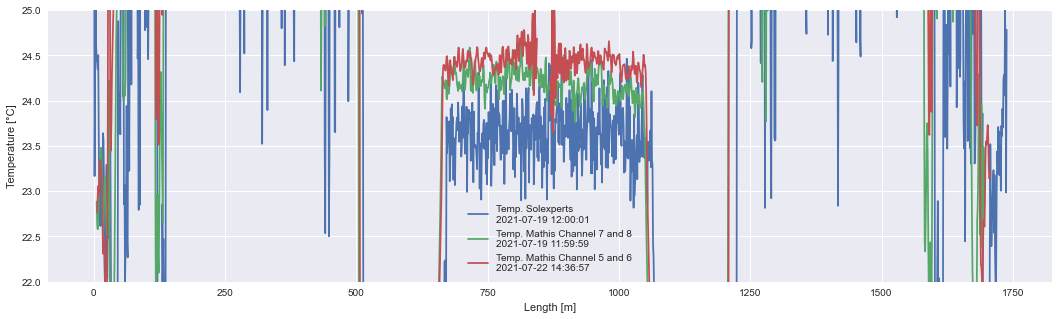

In [21]:
# our data has large data gaps due to watertank temp recording problems. At this dates we have measurements.
date_name_78, iloc_78 = find_nearest_date("19.07.2021 12:00:00",my_final_mean[my_final_mean.columns[:1708]].index)
date_name_56, iloc_56 = find_nearest_date("19.07.2021 12:00:00",my_final_mean_56.index)
date_name_sol, iloc_sol = find_nearest_date("19.07.2021 12:00:00",temp_sol.index)

data_one_date = temp_sol.iloc[iloc_sol]
my_data_one_date = my_final_mean[my_final_mean.columns[:1708]].iloc[iloc_78]
my_data_one_date_56 = my_final_mean_56.iloc[iloc_56+5] # dont use the first measurement, after measurement stopp

plt.figure(figsize=(18,5))
date = data_one_date.name
plt.plot(data_one_date.index, data_one_date.values, label=f"Temp. Solexperts\n{date}")

date = my_data_one_date.name
plt.plot(my_data_one_date.index,my_data_one_date.values, label=f"Temp. Mathis Channel 7 and 8\n{date}")

date = my_data_one_date_56.name
plt.plot(my_data_one_date_56.index,my_data_one_date_56.values, label=f"Temp. Mathis Channel 5 and 6\n{date}")

plt.xlabel("Length [m]")
plt.ylabel("Temperature [°C]")
plt.ylim([22,25])
# plt.xlim([0,100])
# plt.vlines(27,22,25,label="watertank sol", color="black",linestyle="--")
# plt.vlines(25,22,25,label="watertank rwth", color="pink",linestyle="--")
plt.legend()

# Interpretation
# liegt unterschied an unterschiedlicher Wassertanktemperatur? --> nicht nur
# --> hier passt ein shift von 2°C besser, hängt denke ich auch mit Heizphase zusammen. Nein 
# Wassertank und DTS Temp. stimmen eh nicht überein, also ist meine Korrektur unserer Daten nicht passend.
    # Vergleiche nächster Plot, in Heizphasen misst PT_Sensor kältere Temperaturen und in Abkühlphasen wärmere
    #--> bei diesem Messpunkt ist der Einfluss gering (max 0.3 °C)

    # Es gibt also eine unerklärte Differenz von mind 0.3 °C (max 0.6 °C), ist ungefähr im Toleranz bereich aber eigentlich etwas hoch

# wenn ich meine konstante offset Korrektur mache soltle es etwas besser sein.

# bei meinen Messungen ist mean78 immer etwas kühler als mean56: ca. 0.3 °C
# hier ist es genau anders rum

# Am Wassertank sind beide noch gleich in Schacht ist Unterschied zu sehen.
    # das ist mein shiftfirst Ansatz also sind sie nicht beide genau gleich.
    # Man könnte argumentieren, dass ich meine Werte etwas wärmer machen muss anhand von Abweichung.

# !! ältere Datums von mir passen deutlich besser (channel 56 immer zu warm) !!!
    # also hauptproblem doch durch Wassertankkorrektur, die in den heiz / abkühlphasen nicht gut ist?

# Ich könnte mir vorstellen, dass der Unterschied vom Gerät selbst kommt?
# Bin mir nicht sicher, ob das irgendwie durch anderes verschieben oder mitteln verbessert werden kann.

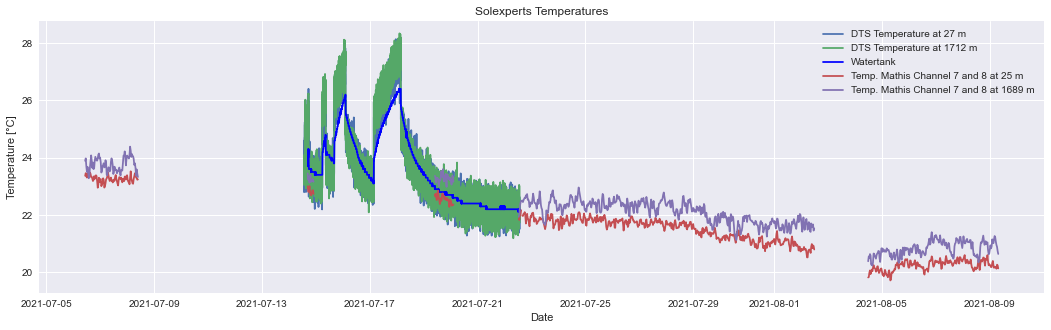

In [22]:
# plot Solexperts temperatures
plt.figure(figsize=(18,5))
watertank_pos=27
plt.plot(temp_sol[temp_sol.columns[watertank_pos]],label=f"DTS Temperature at {watertank_pos} m")
watertank_pos=1712
plt.plot(temp_sol[temp_sol.columns[watertank_pos]],label=f"DTS Temperature at {watertank_pos} m")
plt.plot(tlogger_sol.index,tlogger_sol.values,label="Watertank", color="blue")
plt.title("Solexperts Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.plot(my_final_mean[my_final_mean.columns[19]][1300:], label=f"Temp. Mathis Channel 7 and 8 at 25 m")
plt.plot(my_final_mean[my_final_mean.columns[1683]][1300:], label=f"Temp. Mathis Channel 7 and 8 at 1689 m")
plt.legend()

# Vorallem in Hezphasen können die Temperaturen nicht wirklich verglichen werden, da die DTS MEssungen näher an der Wärmequelle sind.

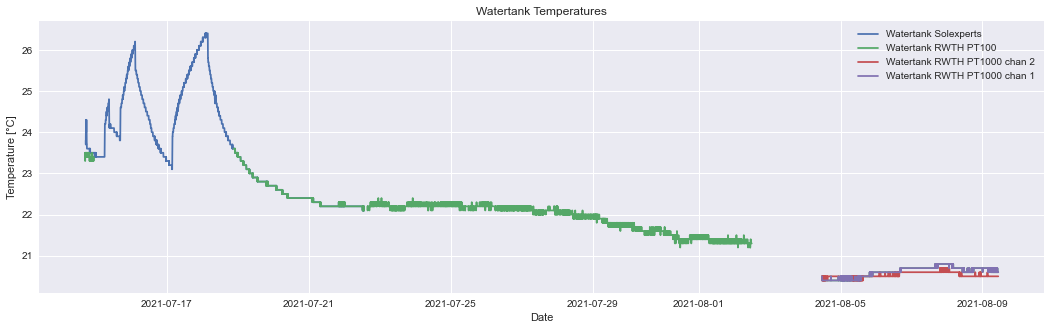

In [23]:
# plot watertank temperatures
plt.figure(figsize=(18,5))
plt.plot(tlogger_sol.index,tlogger_sol.values,label="Watertank Solexperts")
plt.plot(df_Tlogger_PT100["Channel1-Watertank_PT100"].index[15900:],df_Tlogger_PT100["Channel1-Watertank_PT100"].values[15900:],
    label="Watertank RWTH PT100")
# plt.scatter(df_Tlogger_PT100["Channel1-Watertank_PT100"].index[15900:],df_Tlogger_PT100["Channel1-Watertank_PT100"].values[15900:]-1.5,
#     label="Watertank RWTH PT100 shifted: -1.5")
plt.plot(df_Tlogger_PT1000["Channel2_PT1000"].index,df_Tlogger_PT1000["Channel2_PT1000"].values,label="Watertank RWTH PT1000 chan 2")
plt.plot(df_Tlogger_PT1000["Channel1_PT1000"].index,df_Tlogger_PT1000["Channel1_PT1000"].values,label="Watertank RWTH PT1000 chan 1")
plt.title("Watertank Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.legend()

#plt.savefig("pictures/watertank_compare.png")
# Wenn ich meine finalen Werte von channel 1-4 auch um -1.5 °C shifte passen sie ganz gut zum wireline log.
# Wann habe ich die Position von unserem Logger geändert? --> Handbuch Vorort
# Höchstwahrscheinlich sind also die Wassertank Daten, welche von uns gemessen werden falsch.
# Aber ich habe es doch extra nochmal mit dem Handmessgerät überprüft
# darf ich beim Handgerät in den Banannenstecker doch nicht beide rein tun? Wir war vorher nochmal der Unterschied?

In [24]:
# Calculate difference between tlogger and dts temperature
# A difference is expected in the heating phases, because the tlogger measures outside of the cale and the dts system inside
# tlogger at 27 and 1712 in solexperts data
